import packages & selct dataset

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial
import mosaic_topog.utilities as mostop

fold_path = 'C:\\Users\\schle\Documents\\GitHub\\Incubator-2022-Geometry-of-Color\\CSV data all OCT locs Jan 2022\\'

subject = 'AO001R'; # 'AO001R', 'AO008R'
angle = 'temporal' # 'temporal', 'nasal', 'superior', 'inferior'
eccentricity = 1.5; # 1.5, 4, 10

coord_fltype = '.csv'
img_fltype = '.png'

conetype_ids = ['L','M','S','all']
conetype_colors = ['r','g','b','y']
conetype_sizes = [10, 10, 10, 30]

bin_width = 5; #pixels
num_mc = 100; # number of monte carlo mosaics to generate

load in coordinate data and image

In [5]:
prefix = subject + '_' + angle + '_' + str(eccentricity) #convention of filenames

coords = {} #store 2D arrays of each mosaic type
num_type = {}

#load in cone coordinates (relative to ROI lower left corner)
for cone_type in conetype_ids:
    coords[cone_type] = np.loadtxt(fold_path + prefix + '_' + cone_type + coord_fltype, delimiter=',')
    num_type[cone_type] = coords[cone_type][:,0].size
    
#load in ROI image
raw_img = plt.imread(fold_path + prefix + '_raw' + img_fltype);
ROI_x = raw_img.shape[1]
ROI_y = raw_img.shape[0]

plot cones on the image 

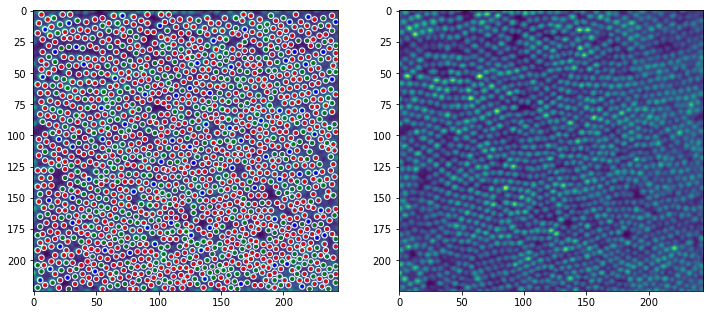

In [6]:
#plot the ROI, then outline all classed cones in yellow and fill in with their respective cone type 
fig, ((ax0, ax1)) = plt.subplots(1,2)
fig.set_size_inches(12,6)

#overlay cone coordinates on the image
ax0.imshow(raw_img)
for ind,cone_type in enumerate(conetype_ids):
    #outline all cones in the 'all' mosaic in white
    if cone_type == 'all':
        csize = 30
        cface = 'none'
        cedge = 'w'
    else: # for 'L', 'M', and 'S' mosaics plot all cones in solid circles of their respective color
        csize = 10
        cface = conetype_colors[ind]
        cedge = 'none'    
    ax0.scatter(x=coords[cone_type][:,0], y=coords[cone_type][:,1], s=csize, facecolors=cface,edgecolors=cedge)
    
#show the plain image
ax1.imshow(raw_img)


plot the cone mosaic types

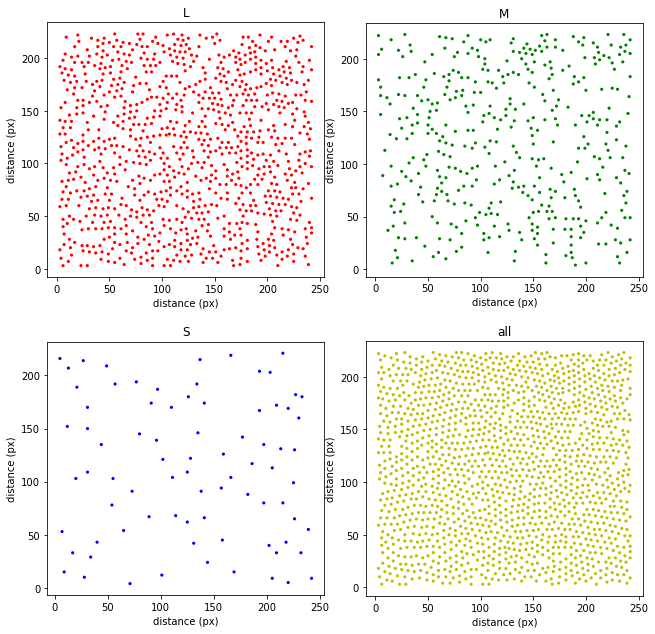

In [7]:
axes = mostop.quad_coord(coords,0,'px',conetype_ids,conetype_colors)

calculate matrix of intercone distances for all cones, L-cones, M-cones, and S-cones

In [8]:
dists = {}
dists_sorted = {}

for cone_type in conetype_ids:
    #2D vector of every cone in the mosaic's distance from every other cone
    dists[cone_type], dists_sorted[cone_type] = mostop.dist_matrices(coords[cone_type])

calculate bin stuff

In [9]:
bin_edges = {}
num_bins = {}

for  ind,cone_type in enumerate(conetype_ids):
    #bin edges from 0 to the largest inter-cone distance
    bin_edges[cone_type] = np.arange(1, int(max(dists_sorted[cone_type]) + bin_width), bin_width)
    num_bins[cone_type] = bin_edges[cone_type].size-1

In [10]:
plot_x = {}
for conetype in conetype_ids:
    plot_x[conetype] = bin_edges[conetype][1:]/2

In [11]:
#plot the bin annuli around a cone at ROI corner

calculate area of each bin/annulus (irrespective of edge effects)

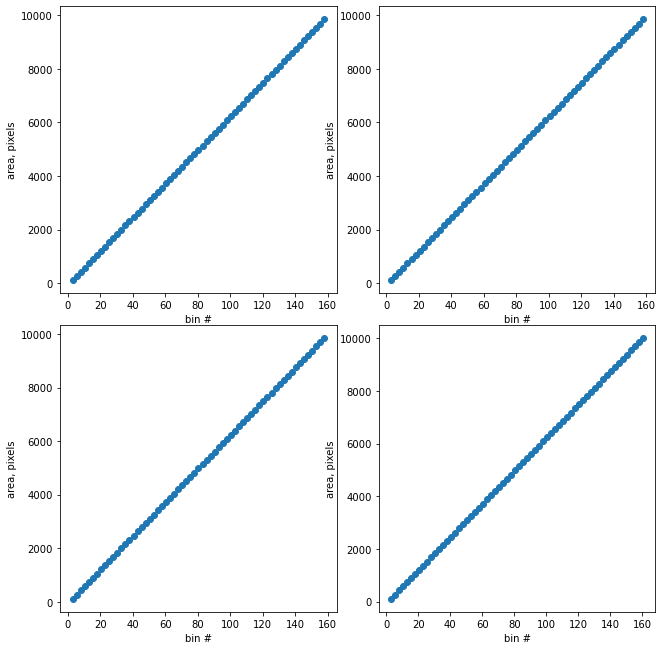

In [12]:
bin_area = {};
axes, fig = mostop.quad_fig([9,9])

for ind,cone_type in enumerate(conetype_ids):
    bin_area[cone_type] = [];
    for ind2,edge in enumerate(bin_edges[cone_type]):
        if ind2 < bin_edges[cone_type].size-1:
            outer_rad = bin_edges[cone_type][ind2+1]
            bin_area[cone_type].append(np.pi * (np.power(bin_edges[cone_type][ind2+1],2) - np.power(edge,2)))

    axes[ind].scatter(plot_x[cone_type],bin_area[cone_type])
    axes[ind].set_xlabel('bin #')
    axes[ind].set_ylabel('area, pixels')

plot histograms of intercone distances

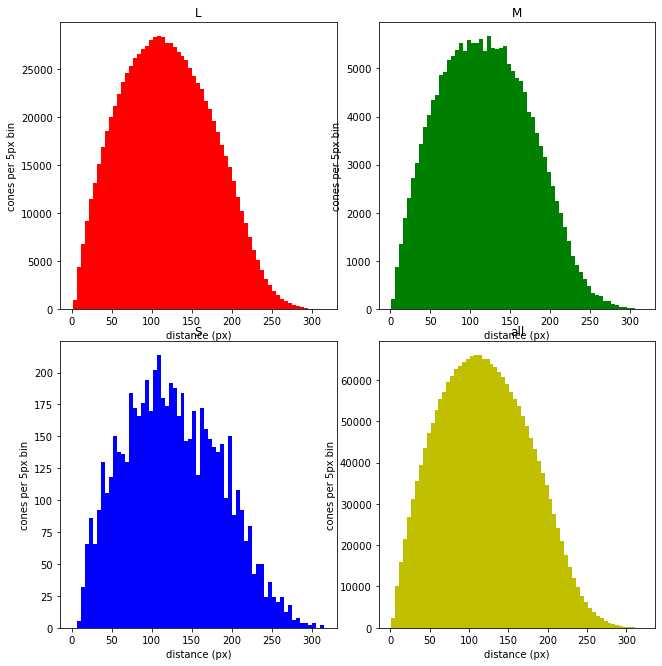

In [13]:
axes = mostop.quad_hist(dists_sorted,bin_edges,'px',conetype_ids,conetype_colors,0)

In [14]:
dir(mostop)

['MonteCarlo_uniform',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'dist_matrices',
 'np',
 'plt',
 'quad_coord',
 'quad_fig',
 'quad_hist',
 'quad_plot',
 'quad_scat',
 'quad_stats',
 'spatial']

generate monte carlo shuffles of the 3 cone-type sub-mosaics as well as the total mosaic

In [15]:
mc_coords = {}

for ind,cone_type in enumerate(conetype_ids):
    ncones = num_type[cone_type]
    
    #generate Monte Carlo mosaics
    mc_coords[cone_type] = mostop.MonteCarlo_uniform(num_mc,num_type[cone_type],[0,ROI_x],[0,ROI_y])  

View one set of monte carlo coordinates

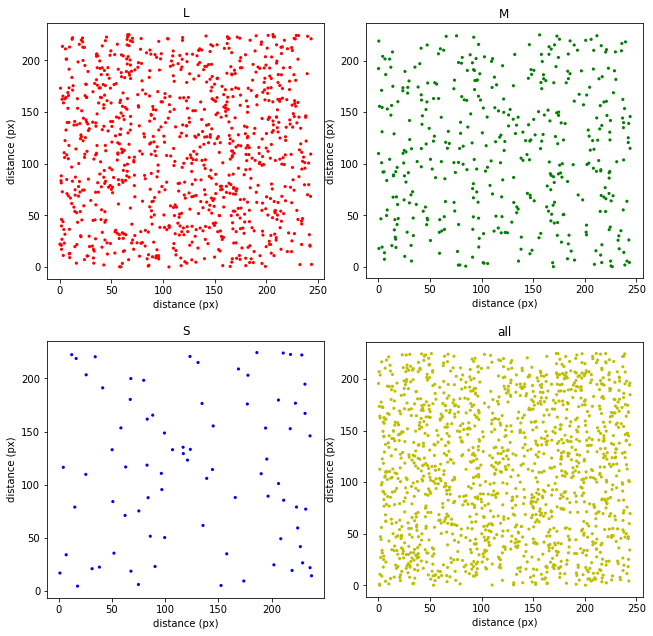

In [17]:
mc_ind = 0
axes = mostop.quad_coord(mc_coords,[mc_ind],'px',conetype_ids,conetype_colors)

calculate distances between all cone types of the Monte Carlo shuffles

In [19]:
mc_dists = {}
mc_dists_sorted = {}
for ind,cone_type in enumerate(conetype_ids): 
    #calculate 
    mc_dists[cone_type],mc_dists_sorted[cone_type] = mostop.dist_matrices(mc_coords[cone_type])

Show histogram of one set of Monte Carlo distances

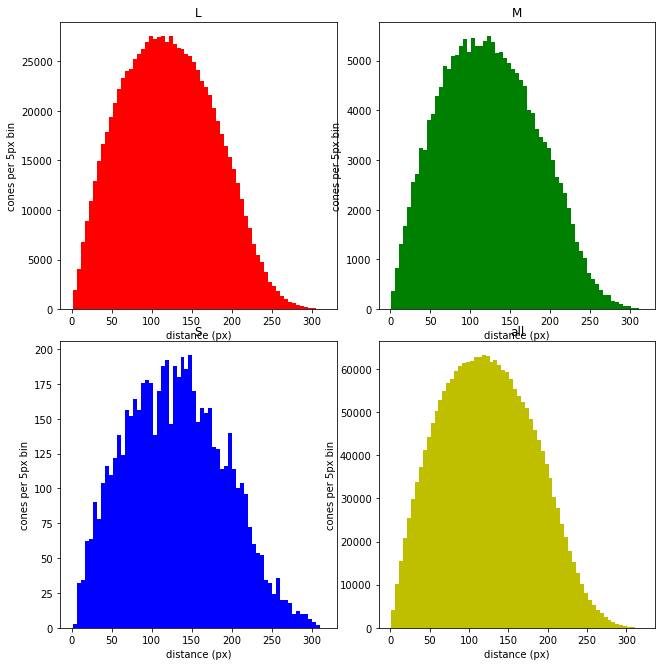

In [23]:
axes = mostop.quad_hist(mc_dists_sorted,bin_edges,'px',conetype_ids,conetype_colors,0)

get distribution of all monte carlo distance histograms as a matrix

In [25]:
mc_hists = {}

for cone_type in conetype_ids:
    mc_hists[cone_type] = np.zeros([num_bins[cone_type],num_mc])
    for mc in np.arange(0,num_mc):
        mc_hists[cone_type][:,mc], edges = np.histogram(mc_dists_sorted[cone_type][:,mc], bins=bin_edges[cone_type])


plot mc hist distribution

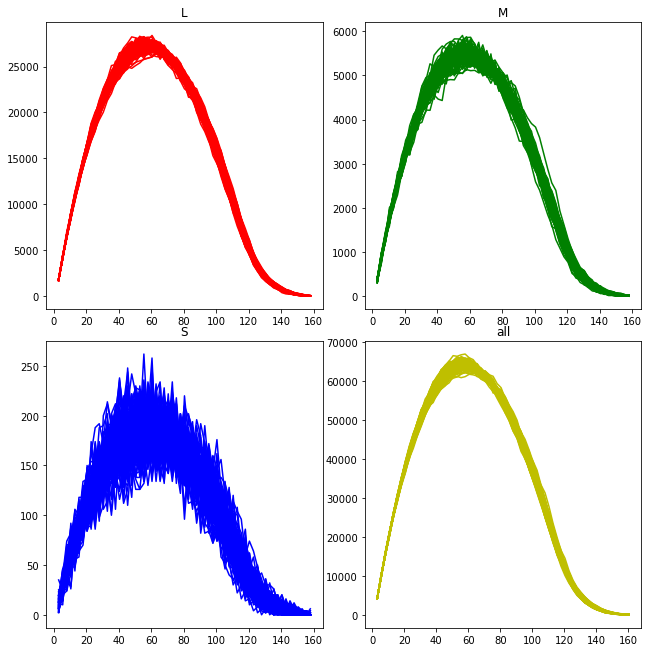

In [26]:
axes,fig = mostop.quad_plot(plot_x,mc_hists,'px',conetype_ids,conetype_colors)

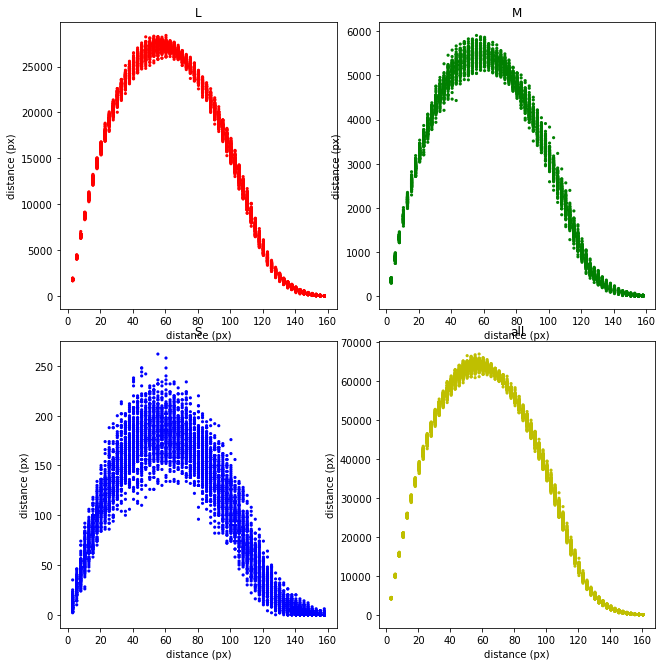

In [27]:
axes,fig = mostop.quad_scat(plot_x,mc_hists,np.arange(0,num_mc),'px',conetype_ids,conetype_colors)

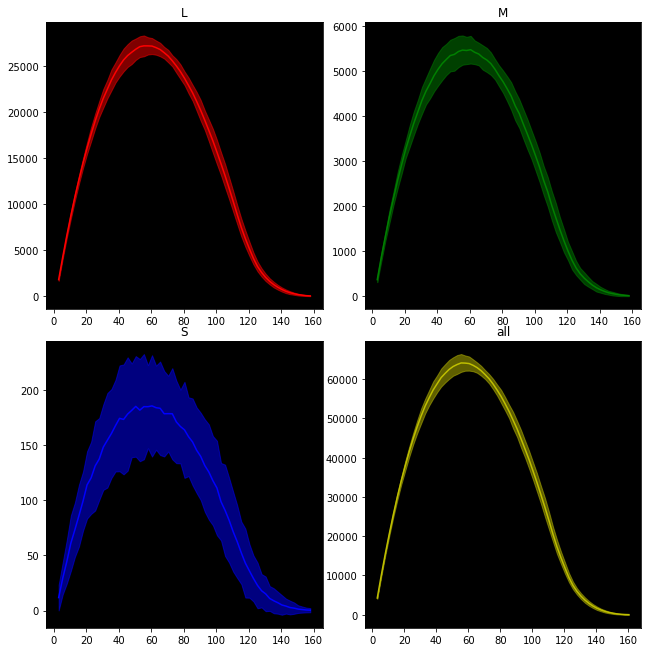

In [28]:
axes, fig, mc_mean,mc_std = mostop.quad_stats(plot_x,mc_hists,2,'px',conetype_ids,conetype_colors)

In [29]:
true_hist = {}

for cone_type in conetype_ids:
    true_hist[cone_type], edges = np.histogram(dists_sorted[cone_type], bins=bin_edges[cone_type])

Overlain true and monte carlo distance histograms

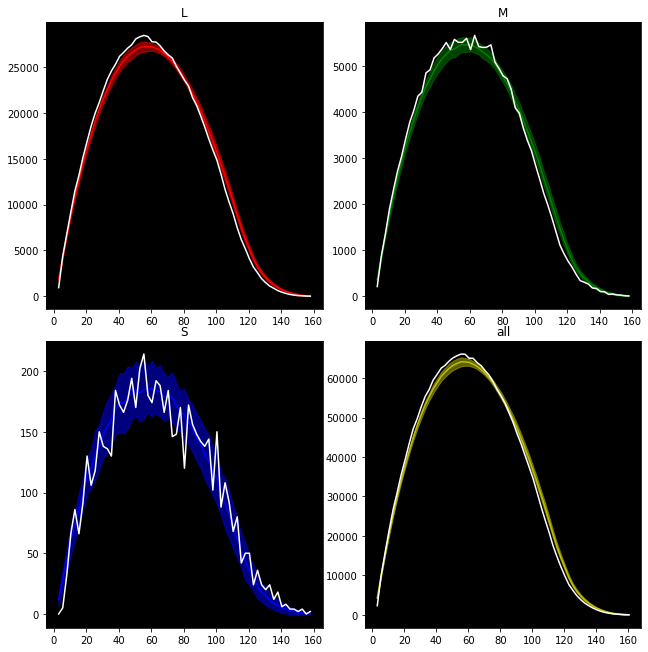

In [30]:
[axes,fig,mc_mean,mc_std] = mostop.quad_stats(plot_x,mc_hists,1,'px',conetype_ids,conetype_colors)

for ind,cone_type in enumerate(conetype_ids):
   axes[ind].plot(plot_x[cone_type],true_hist[cone_type],'w')

normalize real and monte carlo by area (effectively becomes a density measurement impaired by edge effects)

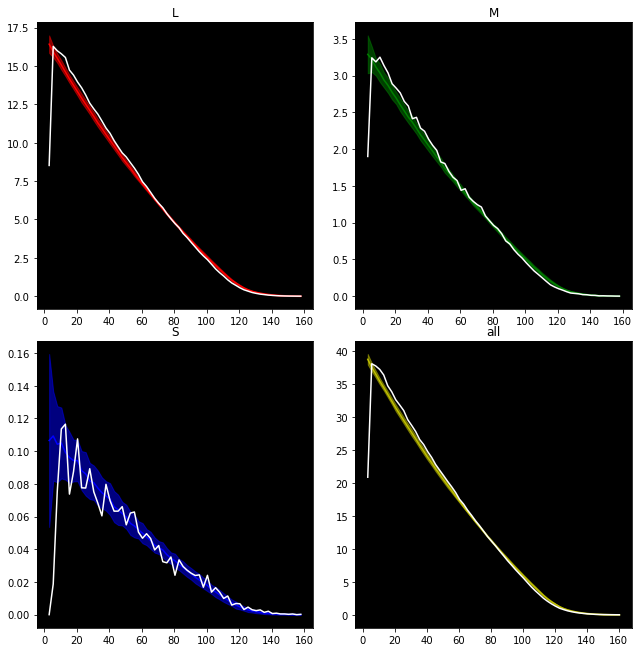

In [32]:
truehist_normed = {}
mchist_normed = {}

for cone_type in conetype_ids:
    truehist_normed[cone_type] = true_hist[cone_type] / bin_area[cone_type]
    mchist_normed[cone_type] = np.zeros([num_bins[cone_type],num_mc])
    for mc in np.arange(0,num_mc):
        mchist_normed[cone_type][:,mc] = mc_hists[cone_type][:,mc] / bin_area[cone_type]

[axes,fig,mc_normed_mean,mc_normed_std] = mostop.quad_stats(plot_x,mchist_normed,1,'px',conetype_ids,conetype_colors)

for ind,cone_type in enumerate(conetype_ids):
   axes[ind].plot(plot_x[cone_type],truehist_normed[cone_type],'w')

normalize by the monte carlo mean

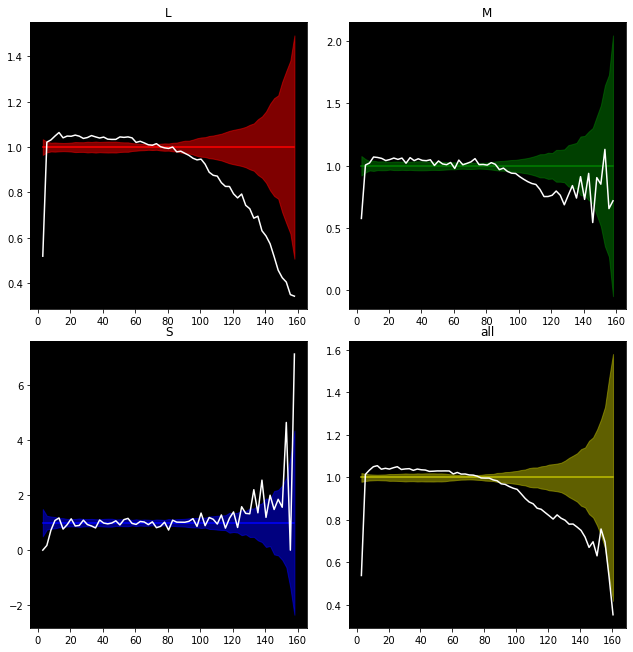

In [33]:
truehist_areamcnormed = {}
mchist_areamcnormed = {}

for cone_type in conetype_ids:
    truehist_areamcnormed[cone_type] = truehist_normed[cone_type] / mc_normed_mean[cone_type]
    mchist_areamcnormed[cone_type] = np.zeros([num_bins[cone_type],num_mc])
    for mc in np.arange(0,num_mc):
        mchist_areamcnormed[cone_type][:,mc] = mchist_normed[cone_type][:,mc] / mc_normed_mean[cone_type]

[axes,fig,mc_mcnormed_mean,mc_mcnormed_std] = mostop.quad_stats(plot_x,mchist_areamcnormed,1,'px',conetype_ids,conetype_colors)

for ind,cone_type in enumerate(conetype_ids):
   axes[ind].plot(plot_x[cone_type],truehist_areamcnormed[cone_type],'w')